In [18]:
import random
import os 

import cv2
import matplotlib.pyplot as plt
import json
from PIL import Image
import numpy as np 

import albumentations as A

In [4]:
    
def boxCreate(points):
    
    x_min = min(points[0][0], points[1][0])
    y_min = min(points[0][1], points[1][1])
    x_max = max(points[0][0], points[1][0])
    y_max = max(points[0][1], points[1][1])

    width = x_max - x_min
    height = y_max - y_min

    return [x_min, y_min, width, height]


def bbox_to_coords(bbox):
    
    x_min, y_min, width, height = bbox
    x_max = x_min + width
    y_max = y_min + height
    
    return [[x_max, y_max],[x_min, y_min]]


def load_json(json_file_path):
    with open(json_file_path, "r") as f:
        return json.load(f)

def shapes_element_maker(transformed, category_id_to_name):
    shapes = []
    for bbox, category_id in zip(transformed['bboxes'], transformed['category_ids']):
        subdict = {
            "label": category_id_to_name[category_id],
            "points": bbox_to_coords(bbox),
            "group_id": 'null',
            "description": "",
            "shape_type": "rectangle",
            "flags": {},
            "mask": 'null'
        }
        shapes.append(subdict)
    return shapes

def save_json(json_dict, json_file_path):
    with open(json_file_path, 'w') as json_file:
        json.dump(json_dict, json_file)


In [5]:
path = '../Database_Whole/Database/'

files = os.listdir(path)
database = [i.replace('.jpg', '') for i in files if i.endswith('.jpg')]


# Categories 

category_name_to_id = {'residential_building':1,
                            'damaged_residential_building':2,
                            'commercial_building':3,
                            'damaged_commercial_building':4,
                            } 
    
    
    
category_id_to_name = {1: 'residential_building',
                            2: 'damaged_residential_building',
                            3:'commercial_building',
                            4:'damaged_commercial_building',
                            }  

In [6]:
pathAugmentation = '../DatabaseAug/'

for file in database:
    
    image_path = path + file + '.jpg'
    json_file_path = path + file + '.json'
    
    # Load your image
    image = Image.open(image_path)

    # Load JSON data
    data = load_json(json_file_path)
    
        
    # Extract bounding boxes and category ids
    bboxes = []
    category_ids = []
    
    for shape in data['shapes']:
        label = shape['label']
        points = shape['points']
        category_ids.append(category_name_to_id[label])
        bboxes.append(boxCreate(points))
        

    # Define the Transformation, here random crop of a 256x256 tile and then padded so it has the same dimensions as the initial pic.
    transform = A.Compose([
        A.RandomCrop(width=256, height=256),
        A.PadIfNeeded(min_height=image.height, min_width=image.width, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0))],
        bbox_params=A.BboxParams(format='coco', label_fields=['category_ids'])
    )
    
    
    image_np = np.array(image)
    transformed = transform(image=image_np, bboxes=bboxes, category_ids=category_ids)

    transformed_image = transformed['image']

    transformed_image_pil = Image.fromarray(transformed_image)

    nameJPG = pathAugmentation + file +'_Aug' +'.jpg'
    nameJSON = pathAugmentation + file +'_Aug' +'.json'
    
    transformed_image_pil.save(nameJPG)

    # Create JSON dictionary for transformed data
    json_dict = {"version": "5.4.1", "flags": {}, "shapes": shapes_element_maker(transformed, category_id_to_name)}

    # Save transformed data to JSON file
    save_json(json_dict, nameJSON)

## Visualise the photos

In [17]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    return np.array(img, dtype=np.uint8)

In [8]:
pathAugmentation = '../DatabaseAug/'

files = os.listdir(pathAugmentation)
database = [i.replace('.jpg', '') for i in files if i.endswith('.jpg')]

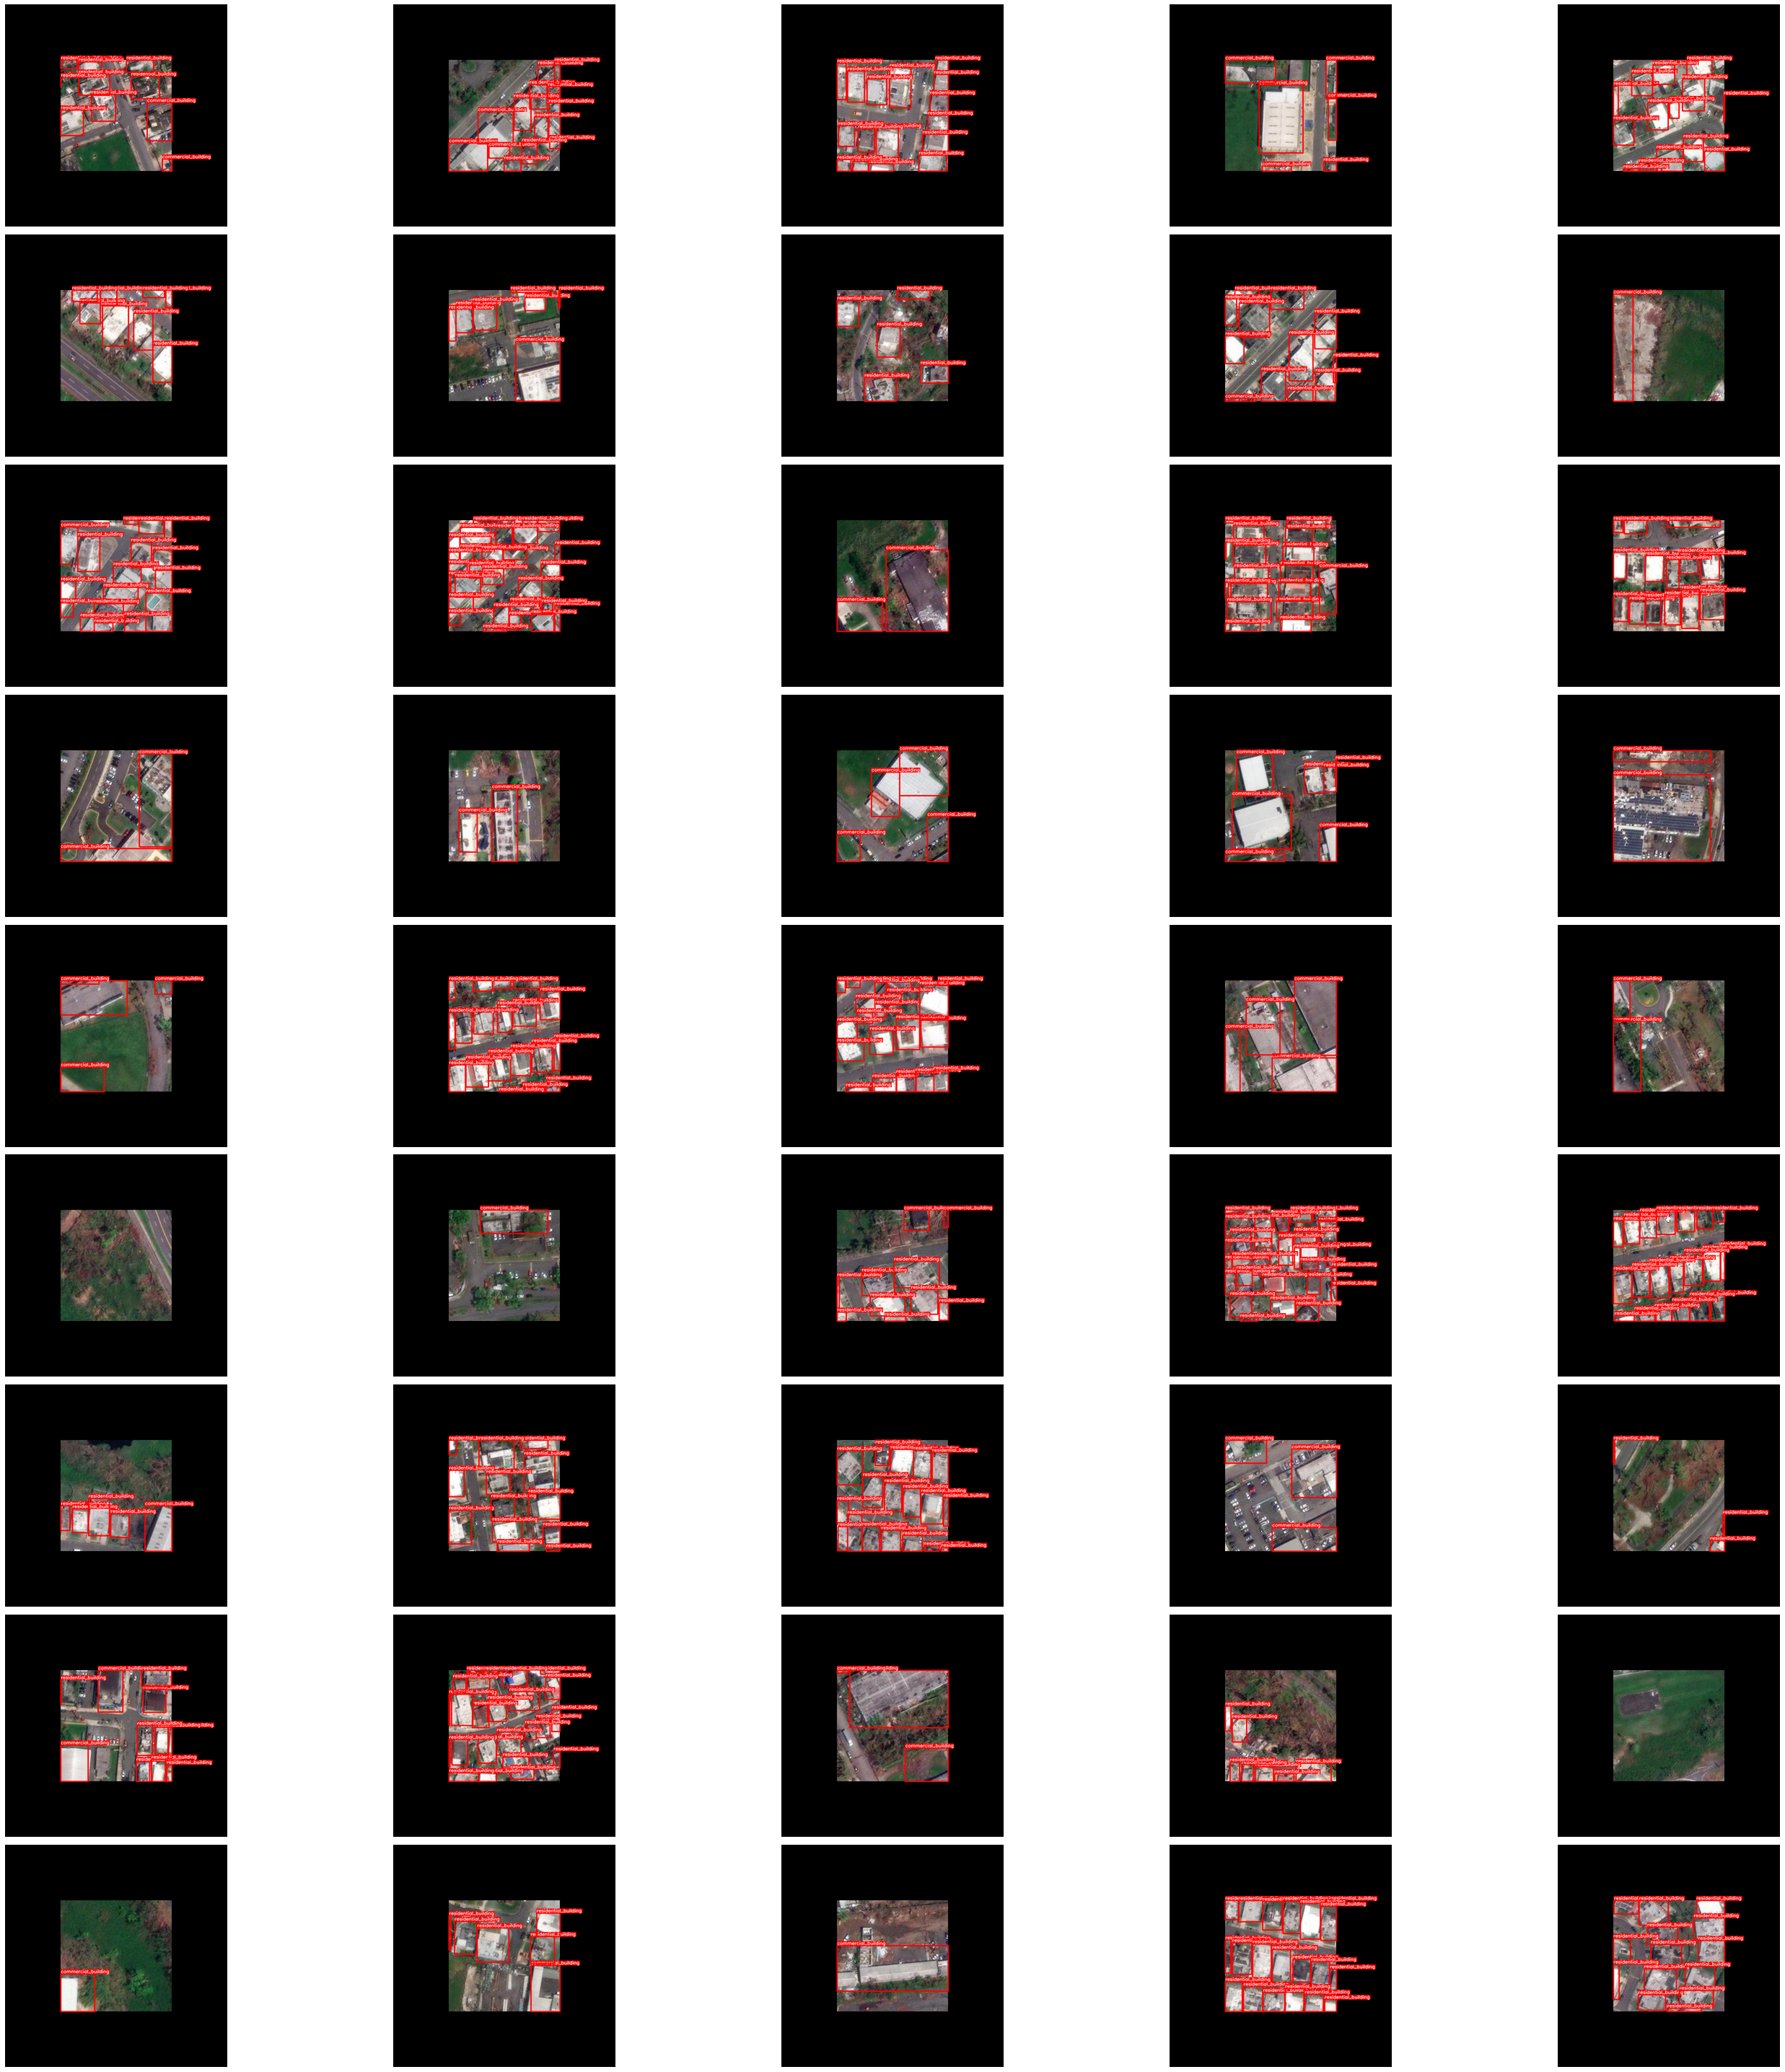

In [19]:
# Initialize subplot
plt.figure(figsize=(40, 40))
plot_number = 1

# Iterate over the database files
for f in database:
    image_file_path = pathAugmentation + f + '.jpg'
    json_file_path = pathAugmentation + f + '.json'

    # Load the image
    image = cv2.imread(image_file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Open the JSON file and load its contents
    with open(json_file_path, "r") as f:
        data = json.load(f)

    bboxes = []
    category_ids = []

    # Extract bounding boxes and category IDs
    for i in range(len(data['shapes'])):
        label = data['shapes'][i]['label']
        shape = data['shapes'][i]['points']
        category_ids.append(category_name_to_id[label])
        bboxes.append(boxCreate(shape))

    # Visualize the image with bounding boxes
    visualized_image = visualize(image, bboxes, category_ids, category_id_to_name)

    # Plot the image
    plt.subplot(9, 5, plot_number)
    plt.imshow(visualized_image)
    plt.axis('off')

    # Increment the plot number
    plot_number += 1

# Show the plot
plt.tight_layout()
plt.show()